# Imports

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import ranksums, ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols

import os
import json

In [56]:
with open('data/paths.json','r') as f:
    paths = json.load(f)

data_path = paths["data_path"]

In [57]:
sns.set(style = 'whitegrid')

# Load data

In [58]:
data = pd.read_csv(os.path.join(data_path,'clean_data.csv'))
data.head()

,sampleNameOnTube,gender,treatment,tissue,injectionVolume,componentName,massInfo,componentGroupName,expectedRt,area,isArea,areaRatio,retentionTime,signalNoise,tissueWeightMg,normalizedArea,pnd,sampleName,isNormalizationFactor,normfactor
0,C20 M1 S,Male,Control,Striatum,10,SM(18:1)+H_d9_SPLASH.IS,738.7 / 184.2,SM,12.51,6.142877e+07,NaN,NaN,12.514791,141.426257,56,NaN,30,20,True,10
1,C20 M1 S,Male,Control,Striatum,10,SM(14:0)+H,675.5 / 184.1,SM,12.51,4.116176e+06,6.142877e+07,0.067007,12.737513,77.971430,56,0.119656,30,20,False,10
2,C20 M1 S,Male,Control,Striatum,10,SM(16:0)+H,703.6 / 184.1,SM,12.51,2.433723e+07,6.142877e+07,0.396186,12.662914,147.602022,56,0.707475,30,20,False,10
3,C20 M1 S,Male,Control,Striatum,10,SM(18:0)+H,731.6 / 184.1,SM,12.51,1.432478e+08,6.142877e+07,2.331933,12.580159,144.222304,56,4.164166,30,20,False,10
4,C20 M1 S,Male,Control,Striatum,10,SM(18:1)+H,729.6 / 184.1,SM,12.51,1.268323e+08,6.142877e+07,2.064706,12.572303,193.985512,56,3.686974,30,20,False,10


# Manipulate data

Extract log value of the target variable

In [59]:
columns_to_transform = ['normalizedArea','areaRatio']

for c in columns_to_transform:
    data['log'+c[0].capitalize()+c[1:]] = data[c].apply(lambda x: np.log(x))

Drop NaN

In [60]:
print(f'Number of points before NaN removal: {data.shape[0]}')
data.dropna(axis=0, subset=['normalizedArea'], inplace=True)
print(f'Number of after before NaN removal: {data.shape[0]}')

Number of points before NaN removal: 57264
Number of after before NaN removal: 31367


Drop normalization factors

In [61]:
data_normalized = data[data['isNormalizationFactor'] == False]
print(f'Number of points after dropping the normalization factors: {data_normalized.shape[0]}')

Number of points after dropping the normalization factors: 31367


In [62]:
data.head()

,sampleNameOnTube,gender,treatment,tissue,injectionVolume,componentName,massInfo,componentGroupName,expectedRt,area,...,retentionTime,signalNoise,tissueWeightMg,normalizedArea,pnd,sampleName,isNormalizationFactor,normfactor,logNormalizedArea,logAreaRatio
1,C20 M1 S,Male,Control,Striatum,10,SM(14:0)+H,675.5 / 184.1,SM,12.51,4.116176e+06,...,12.737513,77.971430,56,0.119656,30,20,False,10,-2.123135,-2.702954
2,C20 M1 S,Male,Control,Striatum,10,SM(16:0)+H,703.6 / 184.1,SM,12.51,2.433723e+07,...,12.662914,147.602022,56,0.707475,30,20,False,10,-0.346053,-0.925871
3,C20 M1 S,Male,Control,Striatum,10,SM(18:0)+H,731.6 / 184.1,SM,12.51,1.432478e+08,...,12.580159,144.222304,56,4.164166,30,20,False,10,1.426516,0.846697
4,C20 M1 S,Male,Control,Striatum,10,SM(18:1)+H,729.6 / 184.1,SM,12.51,1.268323e+08,...,12.572303,193.985512,56,3.686974,30,20,False,10,1.304806,0.724988
5,C20 M1 S,Male,Control,Striatum,10,SM(20:0)+H,759.6 / 184.1,SM,12.51,5.419340e+06,...,12.486523,33.866885,56,0.157538,30,20,False,10,-1.848086,-2.427904


# Figures

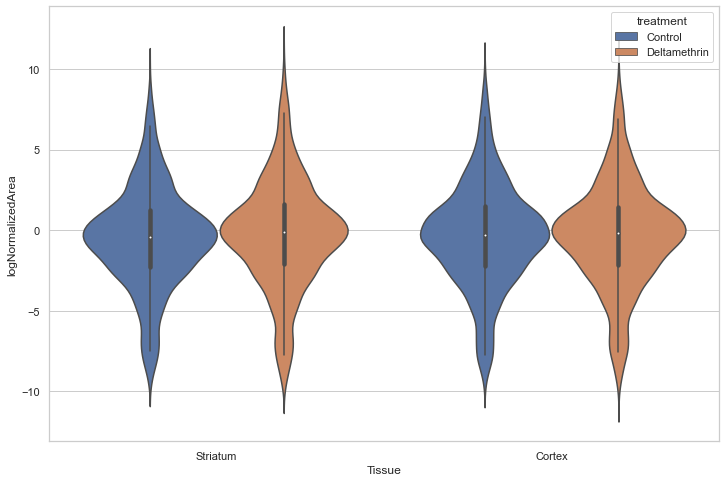

In [63]:
fig100 = plt.figure(figsize=(12,8))
ax = sns.violinplot(data=data, x='tissue', hue='treatment', y='logNormalizedArea')
ax.set_xlabel('Tissue')

fig100.savefig(os.path.join(data_path,"violinplot-tissue.svg"), format='svg', facecolor='w')

plt.show()

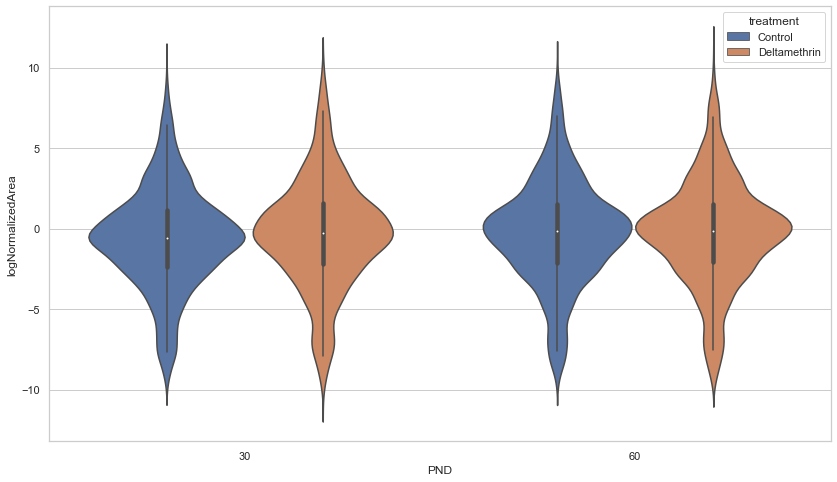

In [64]:
fig = plt.figure(figsize=(14,8))
ax = sns.violinplot(data=data, x='pnd', hue='treatment', y='logNormalizedArea')
ax.set_xlabel('PND')
                    
fig.savefig(os.path.join(data_path,"violinplot-pnd.svg"), format='svg', facecolor='w')

plt.show()

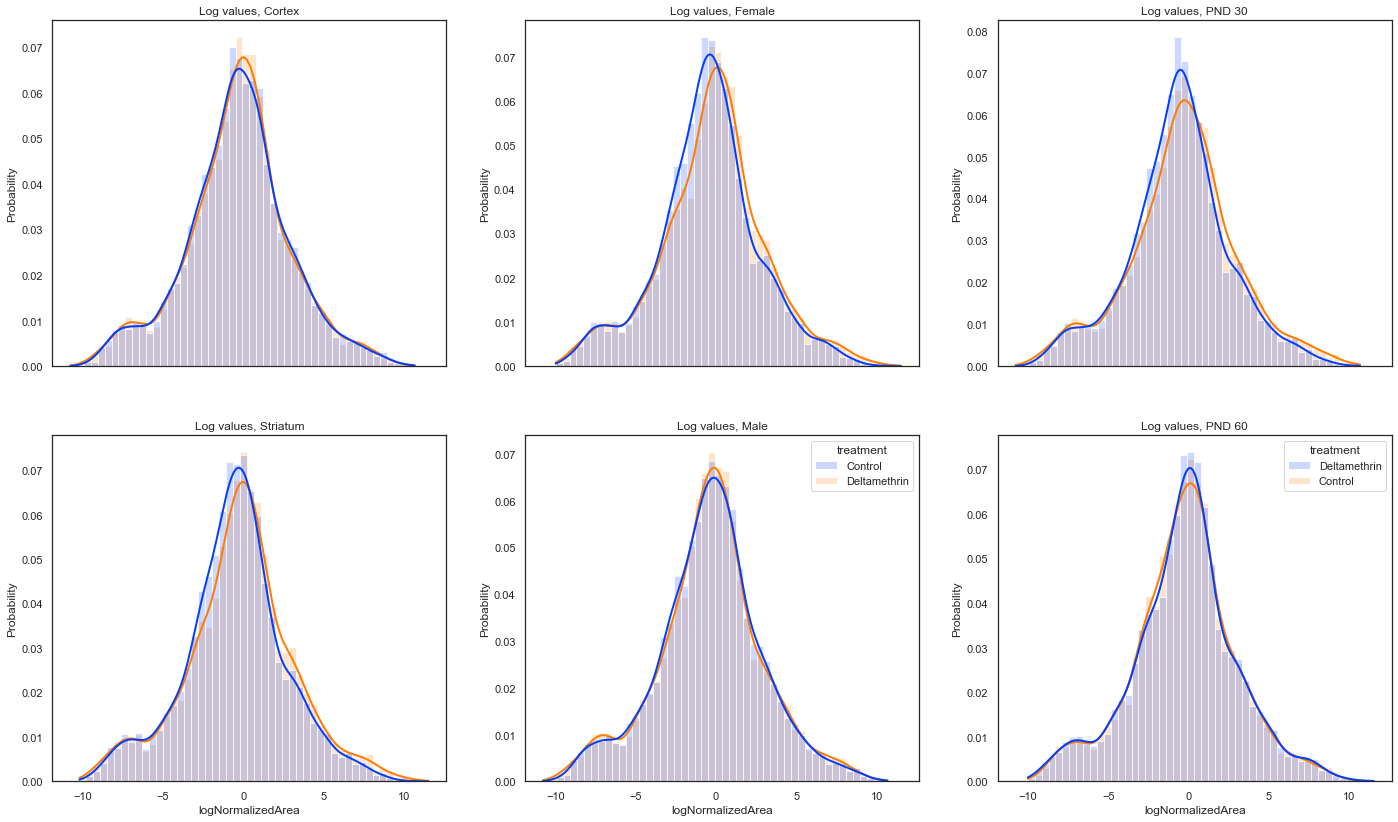

In [65]:
sns.set_style('white')

fig, ax = plt.subplots(2, 3, sharex=True, figsize=(24,14))

opt = {'bins': 50, 'alpha': 0.2, 'palette': 'bright',
        'stat': 'probability', 'kde': True,
        'line_kws': {'lw': 2}, 'common_norm': False}

sns.histplot(data=data[data['tissue'] == 'Cortex'], x='logNormalizedArea', hue='treatment', ax=ax[0,0], legend=False, **opt)
ax[0,0].set_title('Log values, Cortex')
sns.histplot(data=data[data['tissue'] == 'Striatum'], x='logNormalizedArea', hue='treatment', ax=ax[1,0], legend=False, **opt)
ax[1,0].set_title('Log values, Striatum')

sns.histplot(data=data[data['gender'] == 'Female'], x='logNormalizedArea', hue='treatment', ax=ax[0,1], legend=False, **opt)
ax[0,1].set_title('Log values, Female')
sns.histplot(data=data[data['gender'] == 'Male'], x='logNormalizedArea', hue='treatment', ax=ax[1,1], legend=True, **opt)
ax[1,1].set_title('Log values, Male')

sns.histplot(data=data[data['pnd'] == 30], x='logNormalizedArea', hue='treatment', ax=ax[0,2], legend=False, **opt)
ax[0,2].set_title('Log values, PND 30')
sns.histplot(data=data[data['pnd'] == 60], x='logNormalizedArea', hue='treatment', ax=ax[1,2], legend=True, **opt)
ax[1,2].set_title('Log values, PND 60')

fig.savefig(os.path.join(data_path,"distribution-3cases.svg"), format='svg', facecolor='w')

plt.show()

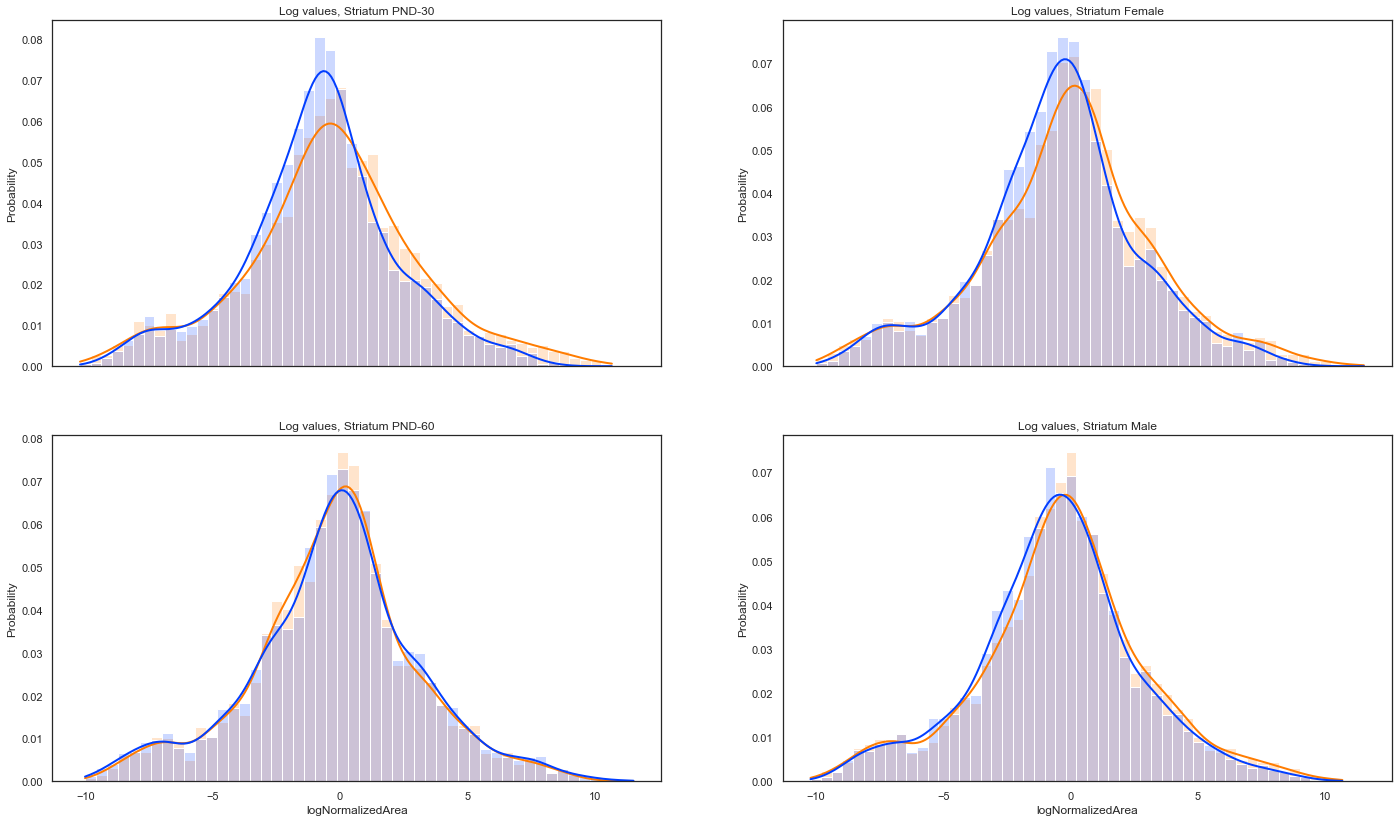

In [66]:
sns.set_style('white')

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(24,14))

opt = {'bins': 50, 'alpha': 0.2, 'palette': 'bright',
        'stat': 'probability', 'kde': True,
        'line_kws': {'lw': 2}, 'common_norm': False}

sns.histplot(data=data[(data['tissue'] == 'Striatum') & (data['pnd'] == 30)], x='logNormalizedArea', hue='treatment', ax=ax[0,0], legend=False, **opt)
ax[0,0].set_title('Log values, Striatum PND-30')
sns.histplot(data=data[(data['tissue'] == 'Striatum') & (data['pnd'] == 60)], x='logNormalizedArea', hue='treatment', ax=ax[1,0], legend=False, **opt)
ax[1,0].set_title('Log values, Striatum PND-60')

sns.histplot(data=data[(data['tissue'] == 'Striatum') & (data['gender'] == 'Female')], x='logNormalizedArea', hue='treatment', ax=ax[0,1], legend=False, **opt)
ax[0,1].set_title('Log values, Striatum Female')
sns.histplot(data=data[(data['tissue'] == 'Striatum') & (data['gender'] == 'Male')], x='logNormalizedArea', hue='treatment', ax=ax[1,1], legend=False, **opt)
ax[1,1].set_title('Log values, Striatum Male')

fig.savefig(os.path.join(data_path,"distribution-Striatum-2cases.svg"), format='svg', facecolor='w')

plt.show()

# Statistics

## Wilcoxon test applied on the data with no normalization

#### Data divided by tissue

In [67]:
tissue = ['Striatum','Cortex']
gender = ['Female', 'Male']
pnd = [30,60]
var_name = 'normalizedArea'


for t in tissue:
    a = data_normalized[(data_normalized['treatment'] == 'Control') & (data_normalized['tissue']==t)][var_name]
    b = data_normalized[(data_normalized['treatment'] == 'Deltamethrin') & (data_normalized['tissue']==t)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Tissue: {t}. P-value: {ranksums(a,b).pvalue:.2e}')

Tissue: Striatum. P-value: 2.73e-10
Tissue: Cortex. P-value: 5.16e-01


#### Data divided by gender

In [68]:
for g in gender:
    a = data_normalized[(data_normalized['treatment'] == 'Control') & (data_normalized['gender']==g)][var_name]
    b = data_normalized[(data_normalized['treatment'] == 'Deltamethrin') & (data_normalized['gender']==g)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Gender: {g}. P-value: {ranksums(a,b).pvalue:.2e}')

Gender: Female. P-value: 8.37e-12
Gender: Male. P-value: 8.43e-01


#### Data divided by PND

In [69]:
for p in pnd:
    a = data_normalized[(data_normalized['treatment'] == 'Control') & (data_normalized['pnd']==p)][var_name]
    b = data_normalized[(data_normalized['treatment'] == 'Deltamethrin') & (data_normalized['pnd']==p)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'PND: {p}. P-value: {ranksums(a,b).pvalue:.2e}')

PND: 30. P-value: 1.18e-08
PND: 60. P-value: 7.67e-01


## T-test applied on the data with log normalization

#### Data divided by tissue

In [70]:
var_name = 'logNormalizedArea'

for t in tissue:
    a = data_normalized[(data_normalized['treatment'] == 'Control') & (data_normalized['tissue']==t)][var_name]
    b = data_normalized[(data_normalized['treatment'] == 'Deltamethrin') & (data_normalized['tissue']==t)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Tissue: {t}. P-value: {ttest_ind(a,b).pvalue:.2e}')

Tissue: Striatum. P-value: 3.43e-08
Tissue: Cortex. P-value: 7.96e-01


#### Data divided by gender

In [71]:
for g in gender:
    a = data_normalized[(data_normalized['treatment'] == 'Control') & (data_normalized['gender']==g)][var_name]
    b = data_normalized[(data_normalized['treatment'] == 'Deltamethrin') & (data_normalized['gender']==g)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Gender: {g}. P-value: {ttest_ind(a,b).pvalue:.2e}')

Gender: Female. P-value: 1.06e-08
Gender: Male. P-value: 9.15e-01


#### Data divided by PND

In [72]:
for p in pnd:
    a = data_normalized[(data_normalized['treatment'] == 'Control') & (data_normalized['pnd']==p)][var_name]
    b = data_normalized[(data_normalized['treatment'] == 'Deltamethrin') & (data_normalized['pnd']==p)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'PND: {p}. P-value: {ranksums(a,b).pvalue:.2e}')

PND: 30. P-value: 1.18e-08
PND: 60. P-value: 7.67e-01


## Three-way ANOVA on log normalized data

#### Quelli singoli sono mediati su tutto il resto. Mentre l'effetto del secondo oridne dice che è vero che partono da livelli differenti diversi striato e corteccia, ma l'effetto del trattamento ha effetto anche se loro sono già diversi

In [73]:
model = ols('logNormalizedArea ~ C(gender) + C(treatment) + C(tissue) + C(gender):C(treatment) + C(tissue):C(treatment)', data=data_normalized).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(gender),9.039819,1.0,0.852519,0.355848
C(treatment),178.285612,1.0,16.813605,0.000041
C(tissue),6.381465,1.0,0.601818,0.437891
C(gender):C(treatment),163.789708,1.0,15.446538,0.000085
C(tissue):C(treatment),146.460044,1.0,13.812227,0.000202
Residual,332541.126817,31361.0,NaN,NaN


In [74]:
model = ols('logNormalizedArea ~ C(gender) + C(pnd) + C(treatment) + C(tissue) + C(pnd):C(treatment) + C(gender):C(treatment) + C(tissue):C(treatment)', data=data_normalized).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(gender),7.618615,1.0,0.719423,0.396340
C(pnd),231.997755,1.0,21.907464,0.000003
C(treatment),117.680768,1.0,11.112552,0.000858
C(tissue),6.948416,1.0,0.656136,0.417933
C(pnd):C(treatment),220.600204,1.0,20.831198,0.000005
C(gender):C(treatment),160.789093,1.0,15.183256,0.000098
C(tissue):C(treatment),142.819208,1.0,13.486366,0.000241
Residual,332088.528858,31359.0,NaN,NaN


### Anova only striatum

In [75]:
data_striatum = data_normalized[data_normalized['tissue'] == 'Striatum'].copy(deep=True)

In [76]:
model = ols('logNormalizedArea ~ C(gender) + C(treatment)  + C(gender):C(treatment)', data=data_striatum).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(gender),89.734457,1.0,8.427262,3.701481e-03
C(treatment),323.772635,1.0,30.406568,3.558374e-08
C(gender):C(treatment),11.147504,1.0,1.046899,3.062380e-01
Residual,168123.086917,15789.0,NaN,NaN


In [77]:
model = ols('logNormalizedArea ~ C(gender) + C(pnd) + C(treatment)+ C(pnd):C(treatment) + C(gender):C(treatment)', data=data_striatum).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(gender),75.449091,1.0,7.110036,7.673166e-03
C(pnd),358.776000,1.0,33.809691,6.194938e-09
C(treatment),145.871980,1.0,13.746423,2.099348e-04
C(pnd):C(treatment),238.473536,1.0,22.472842,2.149959e-06
C(gender):C(treatment),14.597796,1.0,1.375641,2.408627e-01
Residual,167525.837381,15787.0,NaN,NaN


# Heatmap

Index(['componentGroupName', 'sampleNameOnTube', 'treatment',
       'injectionVolume', 'expectedRt', 'area', 'isArea', 'areaRatio',
       'retentionTime', 'signalNoise', 'tissueWeightMg', 'normalizedArea',
       'pnd', 'sampleName', 'isNormalizationFactor', 'normfactor',
       'logNormalizedArea', 'logAreaRatio'],
      dtype='object')


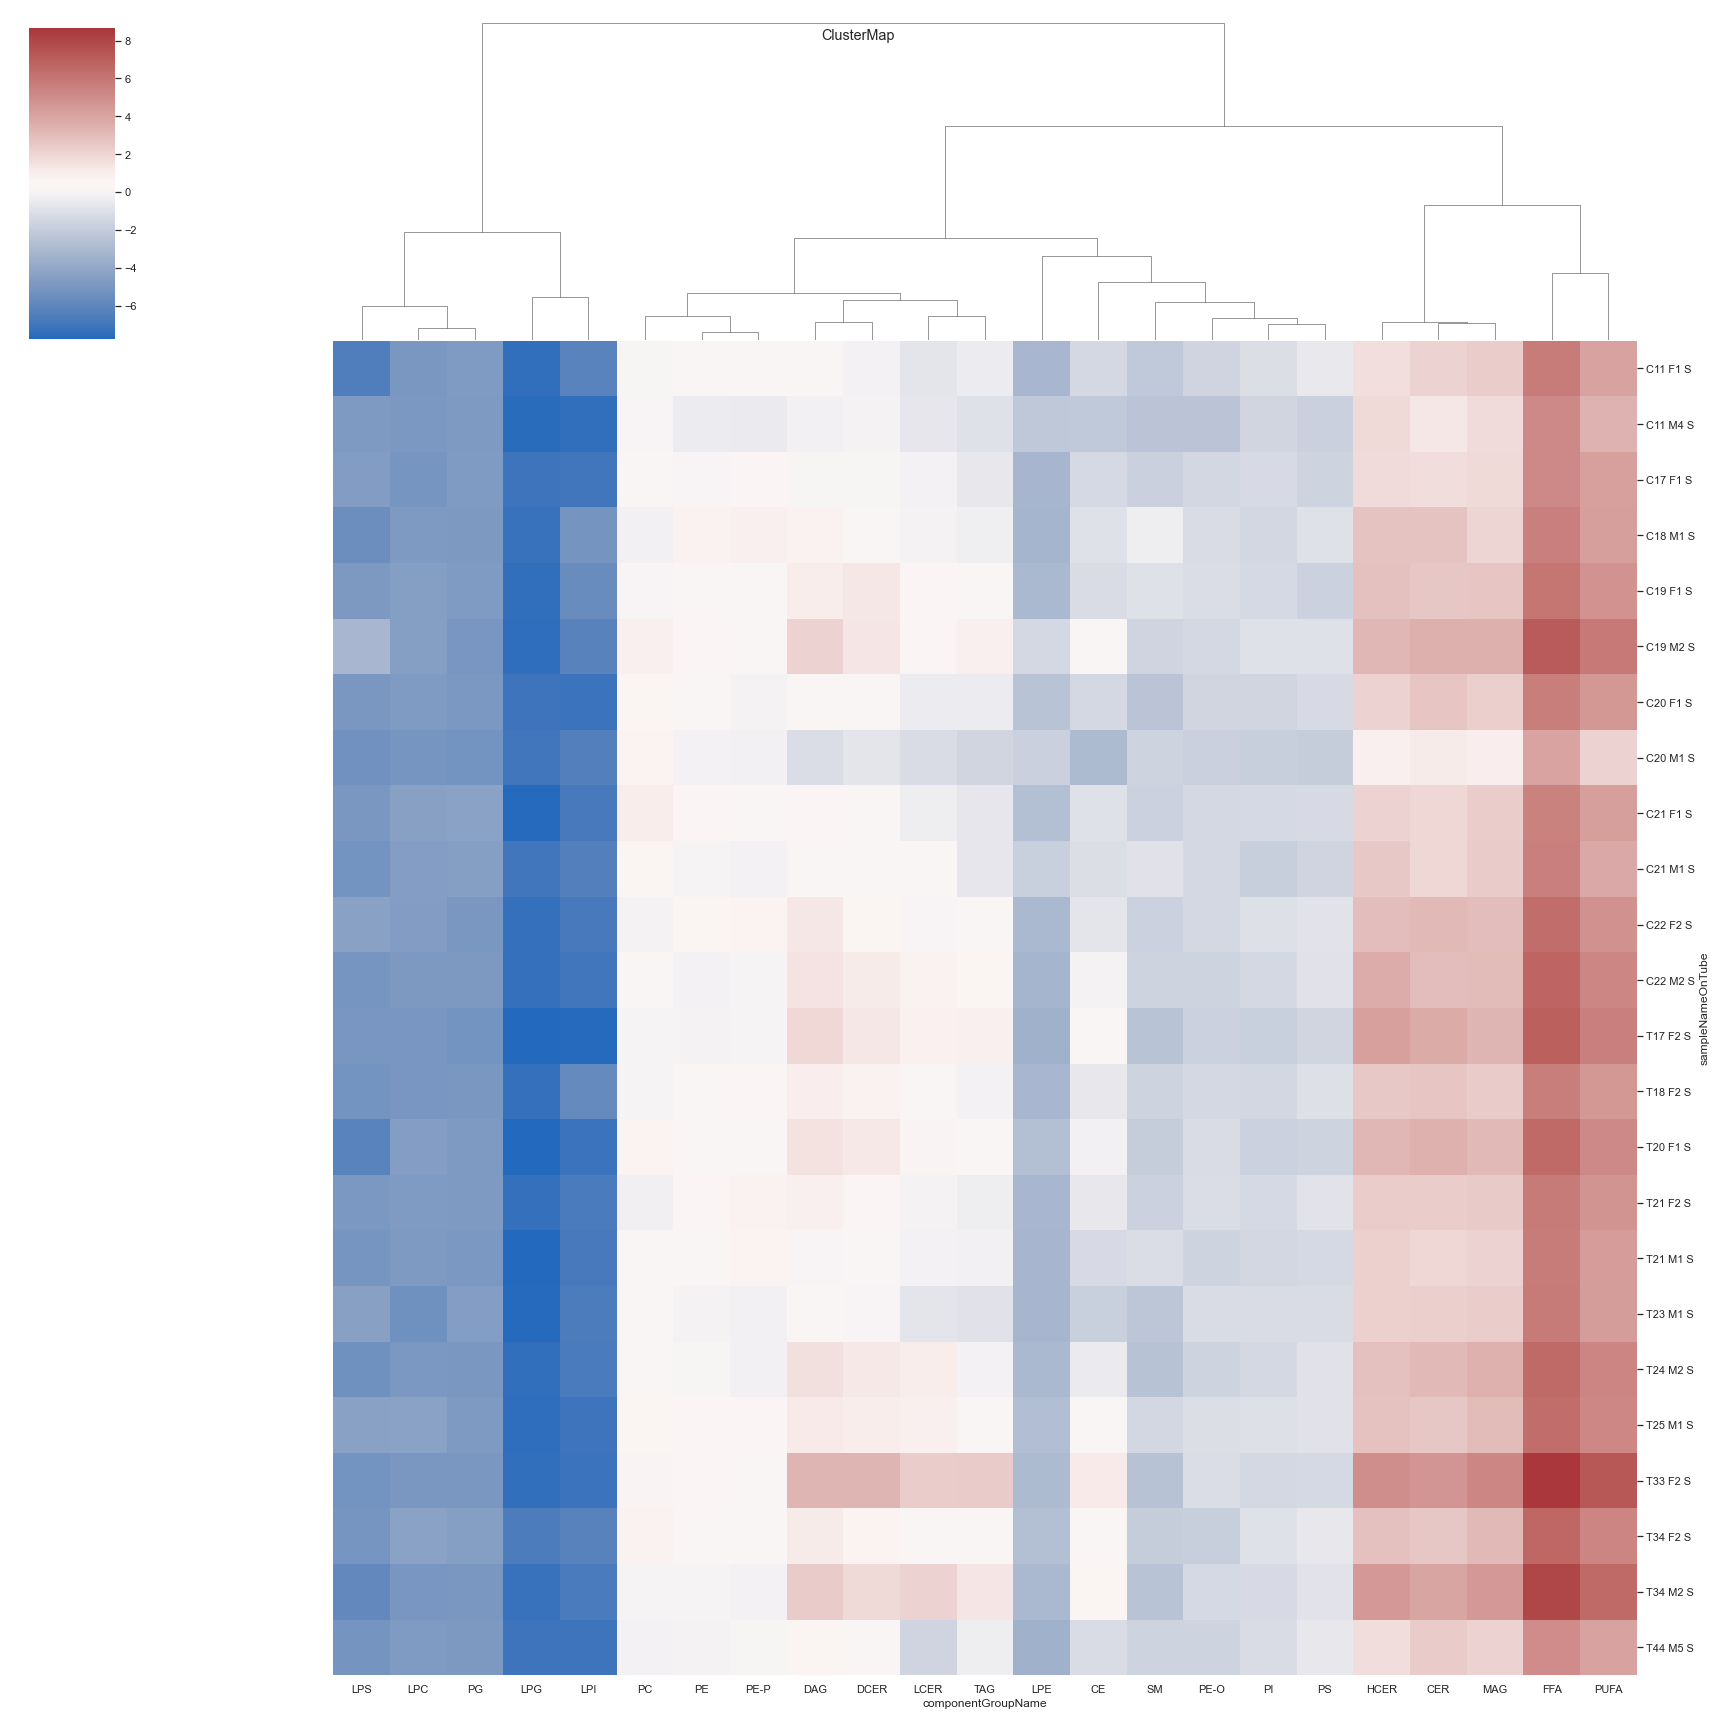

In [86]:
data_grouped = data_striatum.groupby(by=['componentGroupName','sampleNameOnTube']).median().reset_index()
data_grouped.insert(2,'treatment',['Control' if x[0] == 'C' else 'Deltamethrin' for x in data_grouped.iloc[:,1]])
data_grouped.sort_values(by='sampleNameOnTube',inplace=True)
print(data_grouped.columns)
pivot_kws=[
        'sampleNameOnTube',
        'componentGroupName',
        'logNormalizedArea'
]
data_pivot = data_grouped.pivot(*pivot_kws).sort_index()

lut = dict(zip(np.unique([x[0] for x in data_pivot.index]),'rg'))
treatment = pd.Series([x[0] for x in data_pivot.index])
col_colors = treatment.map(lut)
ax = sns.clustermap(data=data_pivot,
        row_cluster=False,
        # row_colors=col_colors,
        figsize=(24,24),cmap='vlag')

ax.figure.savefig(os.path.join(data_path,"test.svg"),format="svg",facecolor="w")

plt.show()

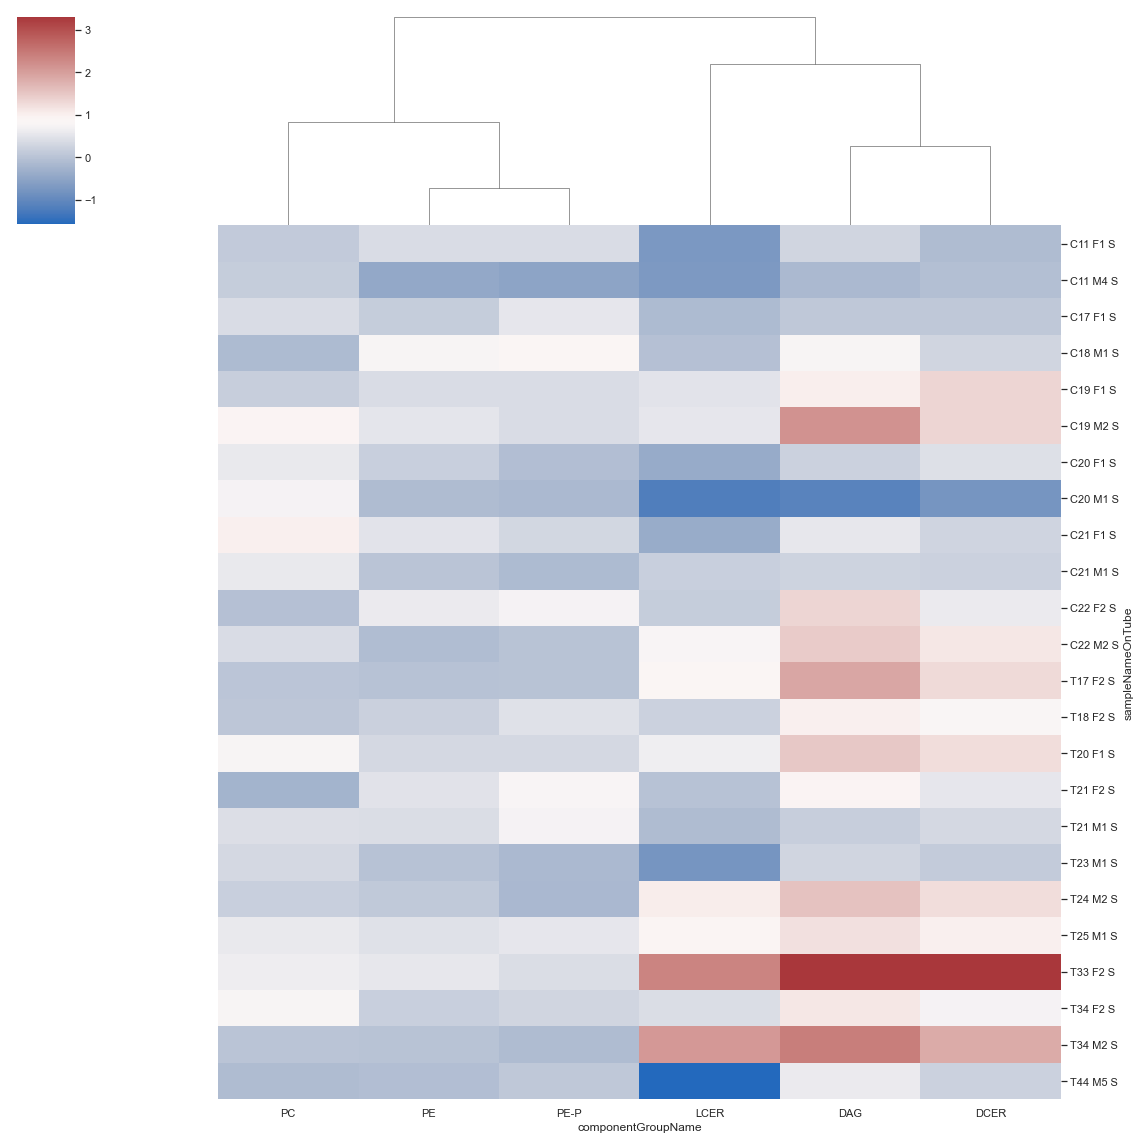

In [87]:
cgn_selected = ['PC','PE','PE-P','DAG','DCER','LCER',
    # 'TAG','LPE','CE','SM','PE-O','PI','PS'
    ]
data_pivot_selected = data_pivot[cgn_selected]
sns.clustermap(data=data_pivot_selected,
        row_cluster=False,
        figsize=(16,16),cmap='vlag')
plt.show()